<a href="https://colab.research.google.com/github/zrmondsc/gedi_waveform_processor/blob/main/notebooks/cnn_regression_3x3_sentinel_to_latent_gedi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Authentication

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import auth
auth.authenticate_user()

## 2. Load and parse tfrecord.gz dataset

In [3]:
# Load dataset from Google Cloud Storage
tfrecord_path = 'gs://ee-gedi-data/tfrecords/gedi_latent_patches_3x3.tfrecord.gz'
raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type='GZIP')

In [8]:
# Sentinel bands and patch size
BANDS = ['VV', 'VH', 'B2', 'B3', 'B4', 'B5', 'B6',
         'B7', 'B8', 'B8A', 'B11', 'B12']
LATENT_KEYS = [f"latent_{i}" for i in range(8)]
PATCH_SIZE = 3

# Feature schema
feature_description = {
    f"{band}_patch": tf.io.FixedLenFeature([PATCH_SIZE * PATCH_SIZE], tf.float32)
    for band in BANDS
}
feature_description.update({
    key: tf.io.FixedLenFeature([], tf.float32) for key in LATENT_KEYS
})

# Parser function
def parse_example(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Reconstruct patch: [3, 3, 12]
    patch = tf.stack([
        tf.reshape(example[f"{band}_patch"], [PATCH_SIZE, PATCH_SIZE])
        for band in BANDS
    ], axis=-1)

    # Combine latents into [8] vector
    latents = tf.stack([example[key] for key in LATENT_KEYS])

    return patch, latents

In [9]:
# Parse dataset
parsed_dataset = raw_dataset.map(parse_example)
parsed_dataset

<_MapDataset element_spec=(TensorSpec(shape=(3, 3, 12), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

## 3. Split data into training and testing datasets

In [12]:
import numpy as np
from tqdm import tqdm

X, y = [], []

# Convert tensors to numpy arrays
for patch, latents in tqdm(parsed_dataset):
    X.append(patch.numpy())
    y.append(latents.numpy())

X = np.array(X)
y = np.array(y)

10546it [00:06, 1540.05it/s]


In [16]:
from sklearn.model_selection import train_test_split

# Split numpy arrays with sk-learn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7382, 3, 3, 12)
X_test shape: (3164, 3, 3, 12)
y_train shape: (7382, 8)
y_test shape: (3164, 8)


In [17]:
# Convert back to a tensor and batch
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

## 4. Build and compile CNN

In [46]:
from tensorflow.keras import layers, models

# Build the Model
def build_model():
    model = models.Sequential([
        layers.Input(shape=(3, 3, 12)),
        layers.Conv2D(64, (2, 2), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8)
    ])
    return model

model = build_model()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 2, 2, 64)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,104 (78.53 KB)

 Trainable params: 20,104 (78.53 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 22509.7168 - mae: 92.9139 - val_loss: 600.5873 - val_mae: 18.6534
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 496.0909 - mae: 16.8658 - val_loss: 288.4759 - val_mae: 13.0486
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 268.6836 - mae: 12.5173 - val_loss: 208.0623 - val_mae: 11.0991
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 202.3556 - mae: 10.8981 - val_loss: 174.5815 - val_mae: 10.2277
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169.3286 - mae: 9.9822 - val_loss: 141.3204 - val_mae: 9.1425
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143.9317 - mae: 9.2044 - val_loss: 128.2736 - val_mae: 8.7038
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 120.4772 - mae: 8.4179 - val_loss: 105.9960 - val_mae: 7.9371
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 106.6086 - mae: 7.9042 - val_loss: 98.4697 - val_mae: 7.6539
Epoch 9

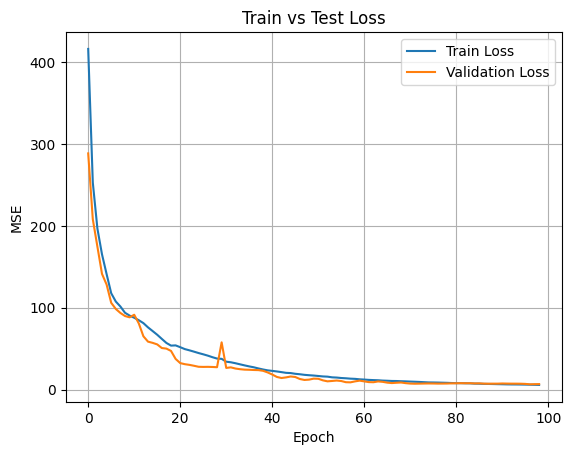

In [51]:
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train vs Test Loss')
plt.grid(True)
plt.legend()
plt.show()